In [364]:
# Imports
from datetime import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Loading Datasets

In [365]:
# file path
file_path="C:/Users/Davie/Desktop/introduction-to-power-bi/"

In [366]:
#load demographic data
demographic=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='CustomerDemographic', index_col=False, header=0, usecols="A:M", skiprows=1)

In [367]:
#load customer address
address=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='CustomerAddress', index_col=False, header=0, usecols="A:F", skiprows=1)

In [368]:
#load transaction data
transactions=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='Transactions', index_col=False, header=0, usecols="A:M", skiprows=1)

In [369]:
#load transaction data
new_customers=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='NewCustomerList', index_col=False, header=0, usecols="A:P", skiprows=1)

### Merging the datasets

In [370]:
#merge demographic data with customer address
demographic_address=pd.merge(demographic, address, on='customer_id', how='inner')

In [371]:
#merged all the 3 datasets
demographic_address_transactions=pd.merge(demographic_address, transactions, on='customer_id', how='inner')

### Data Cleaning

In [372]:
# Drop deceased persons
df=demographic_address_transactions[demographic_address_transactions['deceased_indicator']=='N']

In [373]:
# Drop duplicated customer ids
data=df.dropna(how='any').drop_duplicates()

In [374]:
new_customers.rename(columns={'past_3_years_bike_related_purchases': 'bikes_purchased'}, inplace=True)

In [375]:
cus_data=new_customers[new_customers['deceased_indicator']=='N']

### Feature engineering

##### Target Customers

In [376]:
# Calculate age

# convert DOB to datetime
cus_data['DOB']=pd.to_datetime(cus_data['DOB'], errors='coerce')
# Get the current date
current_date = pd.to_datetime('today')

# Now you can safely calculate age
cus_data['age'] = cus_data['DOB'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)) if pd.notnull(x) else None)

In [377]:
# Define age bins and labels
bins = [0, 20, 30, 40, 50, 60, 70, 100]
labels = ['<20','20-30','30-40','40-50','50-60','60-70', '>70']

# Create age groups
cus_data['age_group'] = pd.cut(cus_data['age'], bins=bins, labels=labels, right=False)

In [378]:
# Define tenure ranges
bins = [0, 5, 10, 15, 25]
labels = ['<5','5-10', '10-15', '>15']

# Create age groups
cus_data['tenure_period'] = pd.cut(cus_data['tenure'], bins=bins, labels=labels, right=False)

In [379]:
# Define proterty valuation ranges
bins = [0, 3, 6, 9, 13]
labels = ['<3','3-6', '6-9', '>9']

# Create age groups
cus_data['valuation_category'] = pd.cut(cus_data['property_valuation'], bins=bins, labels=labels, right=False)

In [380]:
cus_data_col=['first_name', 'last_name', 'gender', 'bikes_purchased','DOB', 'age', 'age_group', 'state',
       'job_title', 'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'tenure_period','property_valuation', 'valuation_category']

In [381]:
targeted_new_customers=cus_data[cus_data_col].dropna(how='any').drop_duplicates()

In [382]:
targeted_new_customers.head()

,first_name,last_name,gender,bikes_purchased,DOB,age,age_group,state,job_title,job_industry_category,wealth_segment,owns_car,tenure,tenure_period,property_valuation,valuation_category
0,Chickie,Brister,Male,86,1957-07-12,66.0,60-70,QLD,General Manager,Manufacturing,Mass Customer,Yes,14,10-15,6,6-9
1,Morly,Genery,Male,69,1970-03-22,54.0,50-60,NSW,Structural Engineer,Property,Mass Customer,No,16,>15,11,>9
2,Ardelis,Forrester,Female,10,1974-08-28,49.0,40-50,VIC,Senior Cost Accountant,Financial Services,Affluent Customer,No,10,10-15,5,3-6
3,Lucine,Stutt,Female,64,1979-01-28,45.0,40-50,QLD,Account Representative III,Manufacturing,Affluent Customer,Yes,5,5-10,1,<3
4,Melinda,Hadlee,Female,34,1965-09-21,58.0,50-60,NSW,Financial Analyst,Financial Services,Affluent Customer,No,19,>15,9,>9


##### Training dataset

In [383]:
#calculate product margin
data['product_margin']=(data['list_price']-data['standard_cost'])/data['list_price']

In [384]:

# Calculate age

# convert DOB to datetime
data['DOB']=pd.to_datetime(data['DOB'], errors='coerce')
# Get the current date
current_date = pd.to_datetime('today')

# Now you can safely calculate age
data['age'] = data['DOB'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)) if pd.notnull(x) else None)

In [385]:
# Define age bins and labels
bins = [0, 20, 30, 40, 50, 60, 70, 100]
labels = ['<20','20-30','30-40','40-50','50-60','60-70', '>70']

# Create age groups
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

In [386]:
# Date of transaction
data['transaction_date'] = pd.to_datetime(data['transaction_date'])

# Extract the daya, monthand year from transaction_date
data['trans_day'] = data['transaction_date'].dt.day
data['trans_month'] = data['transaction_date'].dt.month

In [387]:
# Replace values for gender and state in the entire DataFrame
data['gender'] = data['gender'].replace({'Femal': 'Female', 'F': 'Female'})
data['state']=data['state'].replace({'New South Wales':'NSW','Victoria':'VIC'})

In [388]:
# Define tenure ranges
bins = [0, 5, 10, 15, 25]
labels = ['<5','5-10', '10-15', '>15']

# Create age groups
data['tenure_period'] = pd.cut(data['tenure'], bins=bins, labels=labels, right=False)

In [389]:
# Define proterty valuation ranges
bins = [0, 3, 6, 9, 13]
labels = ['<3','3-6', '6-9', '>9']

# Create age groups
data['valuation_category'] = pd.cut(data['property_valuation'], bins=bins, labels=labels, right=False)

### Distribution for Bikes Purchased to be used as the target variable

<Axes: ylabel='Frequency'>

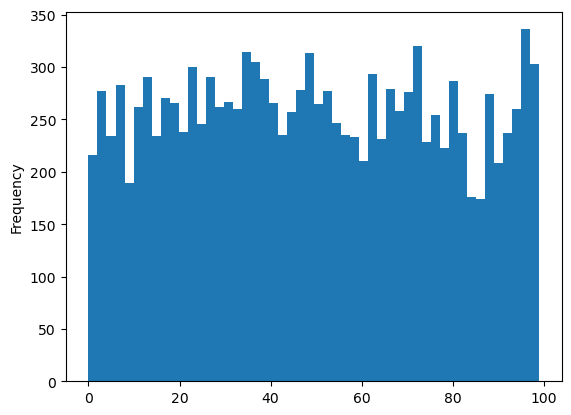

In [390]:
# Histogram

data['past_3_years_bike_related_purchases'].plot.hist(bins=50)

In [399]:
mean=data['past_3_years_bike_related_purchases'].mean()
median=data['past_3_years_bike_related_purchases'].median()
mode=data['past_3_years_bike_related_purchases'].mode()
max=data['past_3_years_bike_related_purchases'].max()
min=data['past_3_years_bike_related_purchases'].min()
print(f'Summary Statistics: {mean}, {median}, {mode}, {min}, {max}')

Summary Statistics: 49.28066656380188, 48.0, 0    48
Name: past_3_years_bike_related_purchases, dtype: int64, 0, 99


<Axes: ylabel='Frequency'>

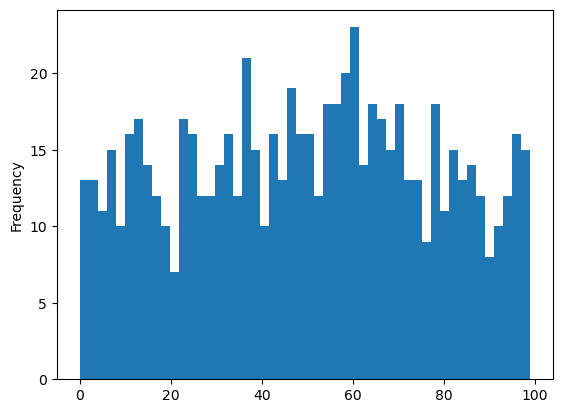

In [403]:
# histogram
targeted_new_customers['bikes_purchased'].plot.hist(bins=50)

In [404]:
mean=targeted_new_customers['bikes_purchased'].mean()
median=targeted_new_customers['bikes_purchased'].median()
mode=targeted_new_customers['bikes_purchased'].mode()
max=targeted_new_customers['bikes_purchased'].max()
min=targeted_new_customers['bikes_purchased'].min()
print(f'Summary Statistics: {mean}, {median}, {mode}, {min}, {max}')

Summary Statistics: 49.806993006993004, 51.0, 0    60
Name: bikes_purchased, dtype: int64, 0, 99


### Columns

In [400]:
data.rename(columns={'past_3_years_bike_related_purchases':'bikes_purchased'},inplace=True)

In [401]:
# Check new columns
data.columns

Index(['customer_id', 'first_name', 'last_name', 'gender', 'bikes_purchased',
       'DOB', 'job_title', 'job_industry_category', 'wealth_segment',
       'deceased_indicator', 'default', 'owns_car', 'tenure', 'address',
       'postcode', 'state', 'country', 'property_valuation', 'transaction_id',
       'product_id', 'transaction_date', 'online_order', 'order_status',
       'brand', 'product_line', 'product_class', 'product_size', 'list_price',
       'standard_cost', 'product_first_sold_date', 'product_margin', 'age',
       'age_group', 'trans_day', 'trans_month', 'tenure_period',
       'valuation_category'],
      dtype='object')

In [402]:
# Select columns to use in the Model
cols=['first_name', 'last_name', 'gender', 'bikes_purchased','DOB', 'age', 'age_group', 'state',
       'job_title', 'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'tenure_period','property_valuation', 'valuation_category'] # should be the same both datasets used

In [ ]:
# Store cleaned data
clean_data=data[cols]
clean_data.to_csv('clean_data.csv', index=False)

In [ ]:
# Load the clean dataset

#clean_data=pd.read_csv('clean_data.csv')
#clean_data.dropna(how='any', inplace=True)

### Encoding, Setting target and feature variables

- Choose the encoding method based on the nature of your data and the requirements of your machine learning model. 
- `One-hot encoding` is suitable when there is no ordinal relationship between categories
- `label encoding` is useful when there is an ordinal relationship between categories. 
- **Example**
    - Label encoding for Ordinal Variables
    - `ordinal_mapping_prod_size = {'small': 0, 'medium': 1, 'large': 2} #product size`
    - `ordinal_data['product_size'] = ordinal_data['product_size'].map(ordinal_mapping_prod_size)`
    - `data.reset_index(drop=True, inplace=True)`  # Reset index of X without adding it as a new column
    - Select categorical columns `categorical_ordinal = ['product_class', 'product_size']`
    - `model_data_class = pd.concat([data_c, encoded_data], axis=1)`
    - Initialize LabelEncoder `label_encoder = LabelEncoder()`
    - Apply Label Encoding to each column `for col in categorical_ordinal:data_clean[col] = label_encoder.fit_transform(data_clean[col])`
- Always remember to handle unknown categories appropriately, especially when using one-hot encoding.

In [ ]:
# Make copy of the data
regression_model_data=clean_data.copy()
#regression_model_data.reset_index(drop=True, inplace=True)
regression_model_data

In [ ]:
# Make copy of the data
regression_target_data=targeted_new_customers.copy()
#regression_model_data.reset_index(drop=True, inplace=True)
regression_target_data

In [ ]:
# I want to detertime customer demographic and product characteristics that influences bike purchase and identify 
# and target customers based on their demographic attributes
# So since only less tha 1% of the customer did not buy bikes, it makes this a regression problem

In [ ]:
# Define categorical columns and numerical columns
categorical_features=['gender', 'bikes_purchased','age_group', 'state',
       'job_title', 'job_industry_category', 'wealth_segment', 'owns_car', 'tenure_period', 'valuation_category']

numerical_features = ['age', 'property_valuation', 'tenure'] 


# Initialize the LabelEncoder
label_encoders = {col: LabelEncoder() for col in categorical_features}

# Encode the regression model data columns
for col in categorical_features:
    regression_model_data[col] = label_encoders[col].fit_transform(regression_model_data[col])

regression_model_data.reset_index(drop=True, inplace=True)

# Encode the targeted new customer data columns
for col in categorical_features:
    regression_target_data[col] = label_encoders[col].fit_transform(regression_target_data[col])

regression_target_data.reset_index(drop=True, inplace=True)


In [ ]:
# Define categorical columns and numerical columns
'''categorical_features = ['gender', 'age_group','state', 'job_industry_category','job_title', 
                     'wealth_segment', 'brand', 'product_line', 
                     'product_class', 'product_size', 'tenure_period', 'valuation_category', 'order_status'] 

numerical_features = ['product_margin', 'property_valuation', 'tenure' ] 

# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps for specific columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])'''


# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Combine preprocessing steps for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'  # Keep all other columns as they are (already preprocessed/one-hot encoded)
)


# Create a pipeline with LogisticRegression
model_ran = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define and the target variable
features_X = regression_model_data.drop(columns=['bikes_purchased','first_name', 'last_name','DOB' ]) #'valuation_category', 'tenure_period',
target_y = regression_model_data['bikes_purchased']

# Adjust the columns as necessary
X_new_customers = regression_target_data[features_X.columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_X, target_y, test_size=0.3, random_state=42)


# Train the model
model_ran.fit(X_train, y_train)

# Predict on the test set
y_pred = model_ran.predict(X_test)

# Evaluate the model
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test, y_pred)
rmse=mse*0.5
r2 = r2_score(y_test, y_pred) #r2 = r2_score(y_val, y_val_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R_squraed (R_Squared): {r2}')


### Preprocessing

### Define Pipelines and Train the model

##### (a) Random Forest
- build a model to predict the likelihood of bike purchases based on demographic and product characteristics

In [ ]:
# Make predictions on the new target customer dataset
new_customer_predictions = model_ran.predict(X_new_customers)

# Define a threshold for selecting customers
threshold = 40  # Example threshold, adjust based on your business needs

# Select customers whose predicted values exceed the threshold
selected_customers = targeted_new_customers[new_customer_predictions > threshold]

# Attach predictions to the selected customer DataFrame
selected_customers = selected_customers.copy()  # Avoid SettingWithCopyWarning
selected_customers['predicted_value'] = new_customer_predictions[new_customer_predictions > threshold]

# Sort customers by their predicted probabilities
target_customers=selected_customers.sort_values(by='predicted_value', ascending=False)

# Save the selected customers to a CSV file (optional)
target_customers.to_csv('selected_customers.csv', index=False)

# Load selected customers data
targeted_customers=pd.read_csv('selected_customers.csv')

'''# predict on the whole dataset
targeted_new_customers['predicted_bikes_purchased']=model_ran.predict(features_X)

# Set threshold for the targeted customers
threshold=90

# Identify customers to the target
target_customers=targeted_new_customers[targeted_new_customers['predicted_bikes_purchased']>threshold]

# Sort customers by their predicted probabilities
target_customers=target_customers.sort_values(by='predicted_bikes_purchased', ascending=False)
target_customers.reset_index(drop=True, inplace=True)
target_customers[['predicted_bikes_purchased', 'state', 'gender', 'age_group']]#.drop_duplicates(subset='customer_id') #['customer_id', 'predicted_bikes_purchased', 'state', 'gender', 'age_group']'''

In [ ]:
targeted_customers

##### (b) Linear Regression

- Logistic regression is used for classification tasks, (not regression). 
- Since we want to determine which demographic and product characteristics influences bike purchases or make customer to purchase the bike, logistic regression is appropriate.

In [ ]:
# Define the model pipeline
model_lin = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_X, target_y, test_size=0.2, random_state=42)

# Train the model
model_lin.fit(X_train, y_train)

# Make predictions
y_pred = model_lin.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')


In [ ]:
'''# Predict prob for the whole data including training and testing sets
predicted_probabilities=model_log.predict_proba(features_X)[:,1]

# Add predicted prob to the original dataset
data['predicted_probabilities']=predicted_probabilities

# Set threshold for the targeted customers
threshold=0.9

# Identify customers to the target
target_customers=data[data['predicted_probabilities']>threshold]

# Sort customers by their predicted probabilities
target_customers=target_customers.sort_values(by='customer_id', ascending=True)

target_customers[['customer_id', 'predicted_probabilities', 'gender', 'tenure_period','age_group','state', 'job_industry_category','job_title', 
                    'order_status', 'wealth_segment', 'brand', 'product_line', 'valuation_category', 'product_class', 'product_size', 'product_margin']]'''

##### (c) Decission Tree

In [ ]:
# Create a pipeline with DecisionTreeClassifier
model_det = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_X, target_y, test_size=0.2, random_state=42)

# Train the model
model_det.fit(X_train, y_train)

# Predict on the test set
y_pred = model_det.predict(X_test)

# Evaluate the model
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test, y_pred)
rmse=mse*0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R_squraed (R_Squared): {r2}')

### STOP

##### DECISSION TREE

In [ ]:
'''# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
#categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'  # Keep all other columns as they are (already preprocessed/one-hot encoded)
)



# Visualize feature importances
# Get feature importances from the trained model
feature_importances = model.named_steps['classifier'].feature_importances_

# Get feature names (numerical + already one-hot encoded features)
feature_names = numerical_features + [col for col in X.columns if col not in numerical_features]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 38))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Decision Tree Classifier')
plt.gca().invert_yaxis()
plt.show()'''

##### LOGISTIC REGRESSION


In [ ]:
'''# Interpret the model coefficients

# Get the feature names after one-hot encoding and scaling
feature_names = numerical_features + [col for col in X.columns if col not in numerical_features]

# Get the coefficients from the logistic regression model
coefficients = model.named_steps['classifier'].coef_[0]

# Create a DataFrame for the coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of the coefficient to see the most influential features
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

#coef_df.to_csv('coj.csv',index=False)

print(coef_df)'''

In [ ]:
'''# Filter coefficients for negative contribution to bike purchases
negative_coef_df = coef_df[coef_df['Coefficient'] < 0]

# Sort coefficients in ascending order (from most negative to least negative)
negative_coef_df = negative_coef_df.sort_values(by='Coefficient', ascending=False)

# Plot the coefficients for negative contribution to bike purchases
plt.figure(figsize=(10, 36))
plt.barh(negative_coef_df['Feature'], negative_coef_df['Coefficient'], color='salmon')
plt.xlabel('Coefficient')
plt.title('Logistic Regression Coefficients for Negative Contribution to Bike Purchases (Most Negative to Least Negative)')
plt.grid(axis='x')
plt.show()'''

In [ ]:
'''# Filter coefficients for positive influence
positive_coef_df = coef_df[coef_df['Coefficient'] > 0]

# Sort coefficients in descending order
positive_coef_df = positive_coef_df.sort_values(by='Coefficient', ascending=True)

# Plot the coefficients for positive influence
plt.figure(figsize=(10, 36))
plt.barh(positive_coef_df['Feature'], positive_coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Logistic Regression Coefficients for Positive Influence')
plt.grid(axis='x')
plt.show()'''

### REGRESSION

In [ ]:
# make copy
reg_data_model=clean_data.copy()
reg_data_model

In [ ]:
# Define numerical and categorical features
numerical_features = ['product_margin'] # 'property_valuation', 'tenure'
categorical_features = ['customer_id','gender','age_group','state','job_industry_category','job_title','online_order','order_status','wealth_segment','brand','product_line','product_class','product_size','tenure_period','valuation_category']

'''[col for col in reg_data_model.columns if col != 'past_3_years_bike_related_purchases' 
                        and col != 'product_margin'
                        and col !='tenure'
                        and col !='property_valuation']'''

In [ ]:
# Select relevant features and the target variable
X = reg_data_model.drop(columns=['past_3_years_bike_related_purchases',  'property_valuation', 'tenure'])
y = reg_data_model['past_3_years_bike_related_purchases']

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps for specific columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

# Feature importance
# Get the feature names from the preprocessor
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
all_features = num_features + cat_features.tolist()

# Get the coefficients
coefficients = model.named_steps['regressor'].coef_

# Create a DataFrame for visualization
coef_df = pd.DataFrame({'Feature': all_features, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 38))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Feature Importance from Linear Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

- Use RandomForestRegressor when your target variable is a continuous value that you need to predict.
- Use RandomForestClassifier when your target variable is a categorical label or class.